### <span style='color:#ff5f27'> 📝 Imports

In [25]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json
import numpy as np

import warnings
warnings.filterwarnings("ignore")

#### Connect to Hopsworks Feature Store </span>

In [26]:
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-06 22:18:38,948 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 22:18:38,990 INFO: Initializing external client
2025-01-06 22:18:38,990 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 22:18:40,487 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207502


In [27]:
# Retrieve feature groups
accidents_fg = fs.get_feature_group(
    name='accidents',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [28]:
# Select features for training data.
selected_features = accidents_fg.select(['accidents']).join(weather_fg.select_all(), on=['date', 'city'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


,accidents,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,14.0,2024-08-15 00:00:00+00:00,19.479584,0.100000,18.359999,175.431091,Stockholm
1,17.0,2024-09-20 00:00:00+00:00,14.717083,0.000000,12.641076,263.211121,Stockholm
2,14.0,2024-09-27 00:00:00+00:00,11.081664,18.000002,14.410121,329.206238,Stockholm
3,6.0,2024-10-05 00:00:00+00:00,8.946250,0.000000,13.608762,240.701645,Stockholm
4,23.0,2024-10-24 00:00:00+00:00,10.964999,0.000000,20.880001,261.377655,Stockholm
5,6.0,2024-10-27 00:00:00+00:00,9.733748,6.200000,23.400002,206.131454,Stockholm
6,22.0,2024-10-31 00:00:00+00:00,7.887916,1.400000,18.116623,244.267090,Stockholm
7,18.0,2024-11-04 00:00:00+00:00,4.056667,0.000000,16.928614,279.599670,Stockholm
8,9.0,2024-11-10 00:00:00+00:00,5.473333,0.100000,9.292255,145.380463,Stockholm
9,4.0,2024-11-30 00:00:00+00:00,4.529583,1.400000,21.677860,229.169464,Stockholm


In [29]:
feature_view = fs.get_or_create_feature_view(
    name='accidents_fv',
    description="weather features with accidents as the target",
    version=1,
    labels=['accidents'],
    query=selected_features,
)

#### Split the training data into train/test data sets </span>

In [30]:
start_date_test_data = "2024-12-01"

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [31]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (10.86s) 


In [32]:
X_train.sort_values(by='date', inplace=True)
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
114,2024-08-01 00:00:00+00:00,17.496252,0.0,14.764390,316.718292,Stockholm
27,2024-08-02 00:00:00+00:00,17.025417,0.0,11.885453,317.973785,Stockholm
92,2024-08-03 00:00:00+00:00,17.908751,0.5,10.009036,319.460907,Stockholm
78,2024-08-04 00:00:00+00:00,17.523336,8.5,7.208994,115.214478,Stockholm
79,2024-08-05 00:00:00+00:00,18.685835,0.4,8.654986,34.007500,Stockholm
...,...,...,...,...,...,...
124,2024-11-26 00:00:00+00:00,5.871250,0.5,19.091883,217.565536,Stockholm
31,2024-11-27 00:00:00+00:00,4.477500,0.1,15.038350,264.764740,Stockholm
74,2024-11-28 00:00:00+00:00,1.327500,0.0,13.350371,351.283630,Stockholm
144,2024-11-29 00:00:00+00:00,0.075417,0.1,17.474840,249.539124,Stockholm


In [33]:
X_test.sort_values(by='date', inplace=True)
X_test

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
87,2024-12-01 00:00:00+00:00,6.315000,0.000000,19.639805,222.447037,Stockholm
10,2024-12-02 00:00:00+00:00,4.615000,3.400000,20.052032,213.260422,Stockholm
22,2024-12-03 00:00:00+00:00,-0.864167,6.200000,21.744267,3.090119,Stockholm
11,2024-12-04 00:00:00+00:00,-3.689167,0.000000,8.604301,39.083725,Stockholm
145,2024-12-05 00:00:00+00:00,-0.330833,0.400000,10.801499,118.384117,Stockholm
65,2024-12-06 00:00:00+00:00,1.925417,0.100000,16.125830,148.958862,Stockholm
134,2024-12-07 00:00:00+00:00,1.225417,0.000000,12.722830,120.137360,Stockholm
75,2024-12-08 00:00:00+00:00,0.719167,0.000000,10.587917,19.437220,Stockholm
57,2024-12-09 00:00:00+00:00,-0.255833,0.000000,13.504799,344.264038,Stockholm
53,2024-12-10 00:00:00+00:00,-2.337083,0.000000,16.946787,274.812103,Stockholm


In [34]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)
train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [35]:
y_train

,accidents
0,14.0
1,17.0
2,14.0
3,6.0
4,23.0
...,...
151,23.0
152,16.0
153,14.0
154,14.0


#### Modeling

In [36]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 93.3743
R squared: -0.22173272795729915


In [38]:
df = y_test
df['predicted_accidents'] = np.round(y_pred).astype(np.int64) #  0.49 -> 0 and 0.5 -> 1

In [39]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(50)

,accidents,predicted_accidents,date
87,5.0,25,2024-12-01 00:00:00+00:00
10,9.0,20,2024-12-02 00:00:00+00:00
22,27.0,20,2024-12-03 00:00:00+00:00
11,22.0,24,2024-12-04 00:00:00+00:00
145,17.0,12,2024-12-05 00:00:00+00:00
65,18.0,12,2024-12-06 00:00:00+00:00
134,14.0,14,2024-12-07 00:00:00+00:00
75,6.0,23,2024-12-08 00:00:00+00:00
57,25.0,14,2024-12-09 00:00:00+00:00
53,22.0,15,2024-12-10 00:00:00+00:00


In [40]:
dates_only = pd.to_datetime(df['date']).dt.date
dates_only

87     2024-12-01
10     2024-12-02
22     2024-12-03
11     2024-12-04
145    2024-12-05
65     2024-12-06
134    2024-12-07
75     2024-12-08
57     2024-12-09
53     2024-12-10
88     2024-12-11
125    2024-12-12
23     2024-12-13
126    2024-12-14
89     2024-12-15
24     2024-12-16
112    2024-12-17
42     2024-12-18
127    2024-12-19
90     2024-12-20
113    2024-12-21
156    2024-12-22
25     2024-12-23
26     2024-12-24
146    2024-12-25
66     2024-12-26
12     2024-12-27
91     2024-12-28
32     2024-12-29
76     2024-12-30
54     2024-12-31
33     2025-01-01
77     2025-01-02
147    2025-01-03
34     2025-01-04
Name: date, dtype: object

In [41]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "accidents_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

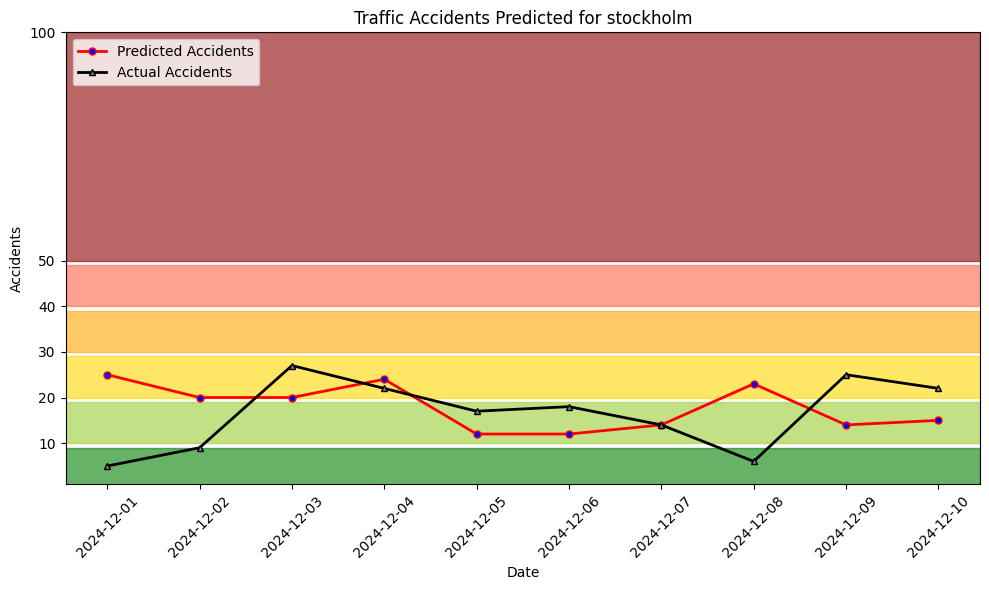

In [42]:
file_path = images_dir + "/accidents_hindcast.png"
plt = util.traf_plot_accidents_forecast("stockholm", df[:10], file_path, hindcast=True)  #cant predict next years val
plt.show()

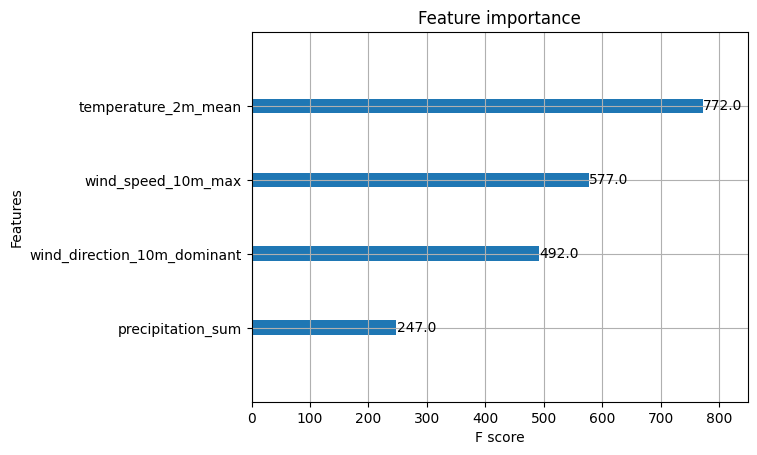

In [44]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [45]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [46]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [47]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [48]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="accident_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="No of accidents predicted using weather data",
)

aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/261209 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/45838 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18967 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/122 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/650 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1207502/models/accident_model/3


Model(name: 'accident_model', version: 3)